In [131]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import psutil
import GPUtil

def get_gpu_utilization():
    # Get the list of available GPUs
    gpus = GPUtil.getGPUs()
    
    if len(gpus) == 0:
        print("No GPU found.")
        return
    
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  - GPU name: {gpu.name}")
        print(f"  - GPU load: {gpu.load * 100:.2f}%")
        print(f"  - GPU memory total: {gpu.memoryTotal} MB")
        print(f"  - GPU memory used: {gpu.memoryUsed} MB")
        print(f"  - GPU memory free: {gpu.memoryFree} MB")
        print(f"  - GPU memory utilization: {gpu.memoryUtil * 100:.2f}%")
        print()

def main():
    # Print CPU utilization
    print("CPU utilization:", psutil.cpu_percent(interval=1))
    
    # Print GPU utilization
    get_gpu_utilization()

if __name__ == "__main__":
    main()


CPU utilization: 0.2
GPU 0:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 24018.0 MB
  - GPU memory free: 199.0 MB
  - GPU memory utilization: 97.78%

GPU 1:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 944.0 MB
  - GPU memory free: 23273.0 MB
  - GPU memory utilization: 3.84%



In [133]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [134]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    #cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)

Num GPUs Available:  2
CPU times: user 43 µs, sys: 6 µs, total: 49 µs
Wall time: 54.6 µs


In [135]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [136]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [137]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [138]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [139]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [140]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [142]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)



In [143]:
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())



In [144]:
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [145]:
%%time


xtrain = xtrain[:8000]
ytrain = ytrain[:8000]

xtest = xtest[:2000]
ytest = ytest[:2000]


CPU times: user 406 µs, sys: 58 µs, total: 464 µs
Wall time: 470 µs


In [146]:
xtrain.shape

(8000, 10, 14)

In [147]:
ytrain.shape[-1]

2

In [148]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]),
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [149]:
xtrain.shape

(8000, 10, 14)

In [150]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x7233bd2870d0>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x7233bd2a4850>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x7233bd2a6650>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x7233bd2a6050>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x7233bd2a6a90>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [151]:
ytrain.shape

(8000, 2)

In [152]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=3,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 3 Complete [00h 00m 42s]
accuracy_score: 0.850125

Best accuracy_score So Far: 0.875125
Total elapsed time: 00h 01m 45s

Top Configurations

-- LSTM | Training Time: 00:01:45
LSTM_num_layers: 2
Dense_num_layers: 0
Adam_learning_rate: 0.00073195506866875
Hyperparameter tuning took 1.7516249497731526 minutes to process.


In [153]:
xtrain

<xarray.DataArray (samples: 8000, timesteps: 10, features: 14)>
array([[[0.33859904, 0.6111059 , 0.66820625, ..., 0.51031161,
         0.94963799, 0.29108656],
        [0.34625976, 0.610469  , 0.59957517, ..., 0.52223226,
         0.95031611, 0.30198682],
        [0.35541507, 0.60855831, 0.53670065, ..., 0.52039935,
         0.94905026, 0.30441461],
        ...,
        [0.39606199, 0.60346323, 0.271232  , ..., 0.50664355,
         0.94986403, 0.36248328],
        [0.40584317, 0.60441852, 0.22642503, ..., 0.50664355,
         0.94846253, 0.36976663],
        [0.41348387, 0.60250769, 0.18740829, ..., 0.50572665,
         0.94895986, 0.37700045]],

       [[0.58921014, 0.51748316, 0.11711755, ..., 0.50572665,
         0.9462925 , 0.35396125],
        [0.5849314 , 0.46525537, 0.13149216, ..., 0.52223226,
         0.94755836, 0.34187187],
        [0.5870709 , 0.41844575, 0.14751628, ..., 0.52681752,
         0.94701588, 0.32859338],
...
        [0.59629781, 0.59589893, 0.64822658, ..., 0.43786754,
         0.91704275, 0.39439132],
        [0.59201932, 0.59717273, 0.74274539, ..., 0.43236582,
         0.91695235, 0.37383442],
        [0.58437888, 0.59462513, 0.82288052, ..., 0.42319528,
         0.91681671, 0.36536194]],

       [[0.60296267, 0.61015056, 0.79806567, ..., 0.4997661 ,
         0.9169071 , 0.52939603],
        [0.60174023, 0.61015056, 0.79724393, ..., 0.4997661 ,
         0.91740444, 0.52576921],
        [0.60204584, 0.610469  , 0.79765497, ..., 0.49884904,
         0.91695235, 0.52818709],
        ...,
        [0.60204584, 0.6091952 , 0.79765497, ..., 0.4997661 ,
         0.91726879, 0.5221424 ],
        [0.60174023, 0.60823986, 0.79765497, ..., 0.4997661 ,
         0.91726879, 0.51971957],
        [0.601129  , 0.60760295, 0.79806567, ..., 0.4997661 ,
         0.91677151, 0.52456028]]])
Coordinates:
  * samples    (samples) int64 3227192 3236491 1127761 ... 2176685 2884230
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [154]:
ytrain.shape

(8000, 2)

In [155]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
63/63 [==============================] - 1s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
63/63 [==============================] - 1s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004058002028614283.
Epoch 5/5
63/63 [==============================] - 1s 3ms/step


In [156]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
0,LSTM,"{'LSTM_num_layers': 2, 'Dense_num_layers': 0, ...",0.874875,0.874875,0.874875,0.874875,0.8865,0.8865,0.8865,0.8865
1,LSTM,"{'LSTM_num_layers': 1, 'Dense_num_layers': 2, ...",0.850125,0.850125,0.850125,0.850125,0.8610,0.8610,0.8610,0.8610
2,LSTM,"{'LSTM_num_layers': 3, 'Dense_num_layers': 2, ...",0.850125,0.850125,0.850125,0.850125,0.8610,0.8610,0.8610,0.8610


In [157]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 2
Dense_num_layers: 0
Adam_learning_rate: 0.00073195506866875



In [181]:
idx = postprocessor._get_idx()
idx

0

In [182]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [174]:
postprocessor.get_model()

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [183]:
 yhat_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
postprocessor.confusion_matrix(model_type = "LSTM")


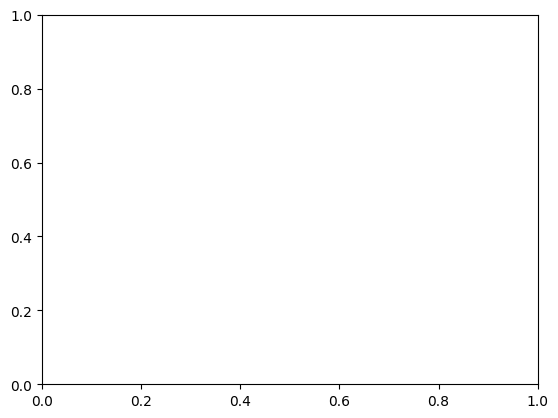

In [185]:
ax = plt.gca()

In [188]:
for y_idx in y:
            # If the column name is given as opposed to the position,
            # find the position
            if isinstance(y_idx, str):
                y_idx = np.where(
                    self._ytest.coords[self._ytest.dims[-1]].values == y_idx
                )[0]

            ax.plot(
                np.linspace(1, ytest.shape[0], ytest.shape[0]),
                np.abs((ytest[:, y_idx] - yhat_test[:, y_idx]) / ytest[:, y_idx]) * 100,
                "-o",
                label=self._ytest.coords[self._ytest.dims[-1]].values[y_idx],
            )

if len(y) > 1:
        ax.legend()

ax.set_xlabel("Testing Data Index")
ax.set_ylabel("Absolute Relative Error (%)")


return ax

NameError: name 'y' is not defined